Created on Thu Apr 18 05:43:21 2024

@author: Santiago D'hers

Use:

- This script will compare the performance of different trained models

Requirements:

- Models trained with 3a-Create_Models.py
- Access to the file colabeled_data.csv, where we can find:
    - Position and labels for representative exploration events
    - It includes the labels of 5 viewers (so far)

In [33]:
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
import random
import datetime

import joblib

# from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from keras.models import load_model

import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [34]:
desktop = 'C:/Users/dhers/Desktop'
STORM_folder = os.path.join(desktop, 'STORM/models')

colabels_file = os.path.join(STORM_folder, 'colabels.csv')
colabels = pd.read_csv(colabels_file)

frames = 7

today = datetime.datetime.now()
# use_model_date = today.date()
use_model_date = '2024-10-21'

objects = ['obj']
bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body']

In [35]:
def recenter(df, point, bodyparts=['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body']):
    # Create a copy of the original dataframe
    df_copy = df.copy()
    bodypart_columns = []
    
    for bodypart in bodyparts:
        # Subtract point_x from columns ending in _x
        x_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_x')]
        df_copy[x_cols] = df_copy[x_cols].apply(lambda col: col - df_copy[f'{point}_x'])
        
        # Subtract point_y from columns ending in _y
        y_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_y')]
        df_copy[y_cols] = df_copy[y_cols].apply(lambda col: col - df_copy[f'{point}_y'])
        
        # Collect bodypart columns
        bodypart_columns.extend(x_cols)
        bodypart_columns.extend(y_cols)
        
    return df_copy[bodypart_columns]

In [36]:
def reshape(df):
    reshaped_df = []
    
    # Iterate over each row index in the DataFrame
    for i in range(len(df)):
        # Determine which indices to include for reshaping
        indices_to_include = [
            max(0, i - 6),  # i - 6, ensure it's not negative
            max(0, i - 3),  # i - 3, ensure it's not negative
            max(0, i - 1),  # i - 1, ensure it's not negative
            i,              # current index
            min(len(df) - 1, i + 1),  # i + 1, ensure it's not out of bounds
            min(len(df) - 1, i + 3),  # i + 3, ensure it's not out of bounds
            min(len(df) - 1, i + 6)   # i + 6, ensure it's not out of bounds
        ]
        
        # Append the rows using the calculated indices
        reshaped_df.append(df.iloc[indices_to_include])
    
    return reshaped_df

In [37]:
# The labels for left and right exploration are on the rest of the columns, we need to extract them
position = colabels.filter(regex='_x|_y').filter(regex='^(?!.*tail)').copy()
                         
lblr_A = colabels.filter(regex='Marian').copy()
lblr_B = colabels.filter(regex='Agus').copy()
lblr_C = colabels.filter(regex='Santi').copy()
lblr_D = colabels.filter(regex='Guille').copy()
lblr_E = colabels.filter(regex='Myself').copy()

labelers = [lblr_A, lblr_B, lblr_C, lblr_D, lblr_E]

geometric = colabels.filter(regex='Geometric').copy() # We dont use the geometric labels to train the model

# Calculate average labels
combined_df = pd.concat(labelers, axis=1)
avrg = pd.DataFrame(combined_df.mean(axis=1), columns=['mean'])

# Apply median filter
avrg['med_filt'] = signal.medfilt(avrg['mean'], kernel_size = 3)

# Gaussian kernel
gauss_kernel = signal.windows.gaussian(3, 0.6)
gauss_kernel = gauss_kernel / sum(gauss_kernel)

# Pad the median filtered data to mitigate edge effects
pad_width = (len(gauss_kernel) - 1) // 2
padded = np.pad(avrg['med_filt'], pad_width, mode='edge')

# Apply convolution
smooth = signal.convolve(padded, gauss_kernel, mode='valid')

# Trim the padded edges to restore original length
avrg['smooth'] = smooth[:len(avrg['mean'])]

# Apply sigmoid function to keep values between 0 and 1
avrg['labels'] = round(1 / (1 + np.exp(-12*(avrg['smooth']-0.5))), 2)

In [38]:
# Load the saved models
model_simple = load_model(os.path.join(STORM_folder, f'simple/model_simple_{use_model_date}.keras'))
model_wide = load_model(os.path.join(STORM_folder, f'wide/model_wide_{use_model_date}.keras'))
RF_model = joblib.load(os.path.join(STORM_folder, f'RF/model_RF_{use_model_date}.pkl'))

In [39]:
def use_model(position, model, objects = ['obj_1', 'obj_2'], bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body'], recentering = True, reshaping = False):
    
    if recentering:
        dfs = []
        for obj in objects:
            recentered = recenter(position, obj, bodyparts)
            dfs.append(recentered)
        position = pd.concat(dfs,ignore_index=True)
    
    if reshaping:
        position = np.array(reshape(position))
    
    pred = model.predict(position) # Use the model to predict the labels
    pred = pred.flatten()
    pred = pd.DataFrame(pred, columns=['predictions'])

    n_objects = len(objects)

    # Calculate the length of each fragment
    fragment_length = len(pred) // n_objects

    # Create a list to hold each fragment
    fragments = [pred.iloc[i*fragment_length:(i+1)*fragment_length].reset_index(drop=True) for i in range(n_objects)]

    # Concatenate fragments along columns
    labels = pd.concat(fragments, axis=1)

    # Rename columns
    labels.columns = [f'{obj}' for obj in objects]
    
    return labels

In [40]:
X_all = position.copy()

all_simple = use_model(X_all, model_simple, objects=['obj'])
all_simple_binary = (all_simple >= 0.5).astype(int) 

all_wide = use_model(X_all, model_wide, objects=['obj'], reshaping = True)
all_wide_binary = (all_wide >= 0.5).astype(int)

all_RF = use_model(X_all, RF_model, objects=['obj'])

5220/5220 [==============================] - 25s 5ms/step


In [41]:
avrg_cont = avrg['labels']
avrg_binary = (avrg_cont >= 0.5).astype(int)

all_labelers = [all_simple_binary, all_wide_binary, all_RF, lblr_A, lblr_B, lblr_C, lblr_D, lblr_E, geometric]
labelers_names = ['simple', 'wide', 'RF', 'lblr_A', 'lblr_B', 'lblr_C', 'lblr_D', 'lblr_E', 'geometric']

for i, labeler in enumerate(all_labelers):
    accuracy = accuracy_score(labeler, avrg_binary)
    precision = precision_score(labeler, avrg_binary, average='weighted')
    recall = recall_score(labeler, avrg_binary, average='weighted')
    f1 = f1_score(labeler, avrg_binary, average='weighted')
    
    mse = mean_squared_error(labeler, avrg_cont)
    mae = mean_absolute_error(labeler, avrg_cont)
    r2 = r2_score(labeler, avrg_cont)

    # Print evaluation metrics along with the labeler's name
    print(f"Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Mean Squared Error = {mse:.4f}, Mean Absolute Error = {mae:.4f}, R-squared = {r2:.4f} -> {labelers_names[i]}")

Accuracy = 0.9840, Precision = 0.9839, Recall = 0.9840, F1 Score = 0.9839, Mean Squared Error = 0.0127, Mean Absolute Error = 0.0185, R-squared = 0.7856 -> simple
Accuracy = 0.9849, Precision = 0.9849, Recall = 0.9849, F1 Score = 0.9849, Mean Squared Error = 0.0119, Mean Absolute Error = 0.0177, R-squared = 0.7941 -> wide
Accuracy = 0.9878, Precision = 0.9875, Recall = 0.9878, F1 Score = 0.9876, Mean Squared Error = 0.0105, Mean Absolute Error = 0.0163, R-squared = 0.8297 -> RF
Accuracy = 0.9828, Precision = 0.9829, Recall = 0.9828, F1 Score = 0.9819, Mean Squared Error = 0.0124, Mean Absolute Error = 0.0182, R-squared = 0.8265 -> lblr_A
Accuracy = 0.9776, Precision = 0.9855, Recall = 0.9776, F1 Score = 0.9799, Mean Squared Error = 0.0184, Mean Absolute Error = 0.0242, R-squared = 0.5173 -> lblr_B
Accuracy = 0.9705, Precision = 0.9709, Recall = 0.9705, F1 Score = 0.9681, Mean Squared Error = 0.0235, Mean Absolute Error = 0.0293, R-squared = 0.7105 -> lblr_C
Accuracy = 0.9862, Precision

In [42]:
avrg_values = [round(1/len(labelers) * i, 2) for i in range(len(labelers))]

df = pd.DataFrame()

for i in avrg_values:
    df[f"avrg_{i}"] = (avrg_cont > i).astype(int)
for name, data in zip(labelers_names, all_labelers):
    df[name] = data

df.head()

,avrg_0.0,avrg_0.2,avrg_0.4,avrg_0.6,avrg_0.8,simple,wide,RF,lblr_A,lblr_B,lblr_C,lblr_D,lblr_E,geometric
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


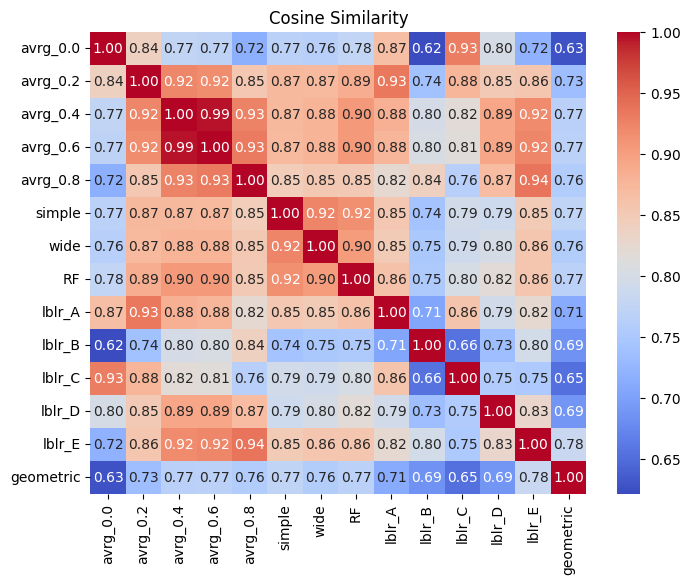

In [43]:
# Compute Cosine similarity

cosine_sim = pd.DataFrame(cosine_similarity(df.T), index=df.columns, columns=df.columns)

# Plot Cosine similarity heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim.astype(float), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cosine Similarity")
plt.show()

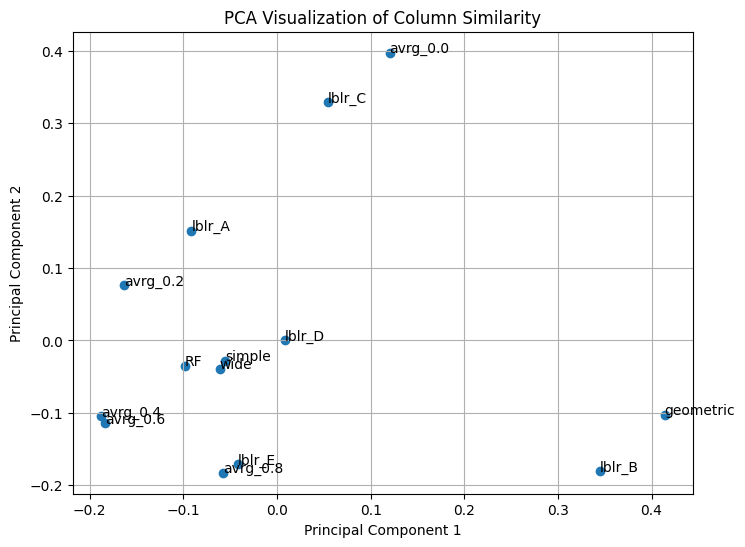

In [44]:
from sklearn.decomposition import PCA

# Use PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cosine_sim)

# Plot the 2D representation
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])

# Annotate the points with column names
for i, column in enumerate(df.columns):
    plt.annotate(column, (pca_result[i, 0], pca_result[i, 1]))

plt.title("PCA Visualization of Column Similarity")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

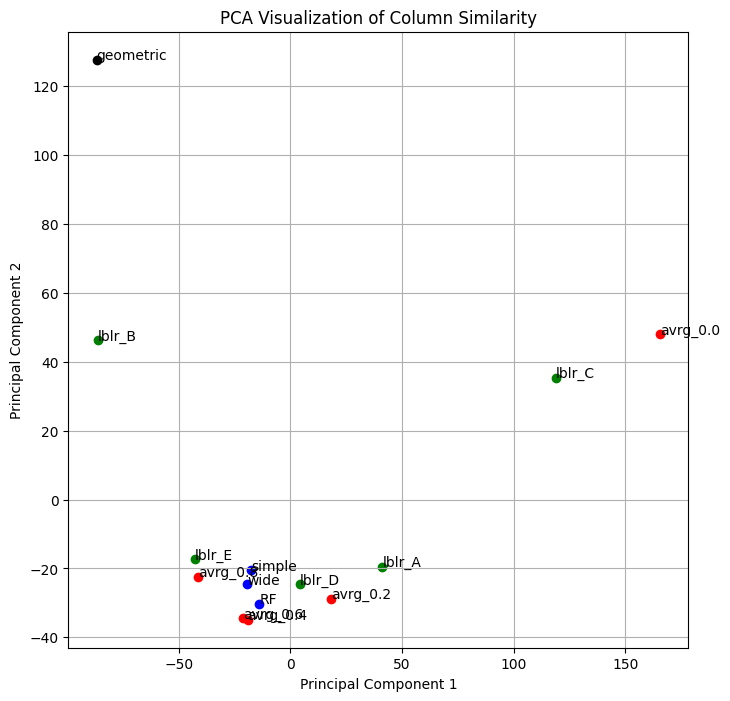

Explained variance ratio: [0.33695104 0.15260603]


In [45]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Transpose the DataFrame to analyze columns
df_transposed = df.T

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_transposed)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Add the principal components to the original DataFrame
df_pca = pd.concat([df_transposed.reset_index(), pca_df], axis=1)

# Plot the principal components
plt.figure(figsize=(8, 8))

# Plot the first 5 points in a different color
plt.scatter(pca_df['PC1'][:5], pca_df['PC2'][:5], color='red', label='Tresholds')
plt.scatter(pca_df['PC1'][5:8], pca_df['PC2'][5:8], color='blue', label='Models')
plt.scatter(pca_df['PC1'][8:13], pca_df['PC2'][8:13], color='green', label='Labelers')
plt.scatter(pca_df['PC1'][13], pca_df['PC2'][13], color='black', label='Geometric')

for i in range(len(pca_df)):
    plt.text(pca_df['PC1'][i], pca_df['PC2'][i], df_transposed.index[i])

plt.title("PCA Visualization of Column Similarity")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# Print explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)

Now we can use the models in an example video

In [46]:
# Prepare the dataset of a video we want to analyze and see
X_view = pd.read_csv(os.path.join(STORM_folder, 'example/Example_position.csv')).filter(regex='^(?!.*tail)')
video_path = os.path.join(STORM_folder, 'example/Example_video.mp4')

labels_A = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Marian.csv'))
labels_B = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Agus.csv'))
labels_C = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Santi.csv'))
labels_D = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Guille.csv'))
labels_E = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Dhers.csv'))

dfs_example = [labels_A, labels_B, labels_C, labels_D, labels_E]

# Calculate average labels
sum_df_example = pd.DataFrame()
for df in dfs_example:
    sum_df_example = sum_df_example.add(df, fill_value=0)
avrg_example = sum_df_example / len(dfs_example)

In [47]:
autolabels_simple = use_model(X_view, model_simple)
autolabels_wide = use_model(X_view, model_wide, reshaping = True)
autolabels_RF = use_model(X_view, RF_model)

469/469 [==============================] - 2s 5ms/step


In [48]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add traces for each label set
fig.add_trace(go.Scatter(x=list(range(len(labels_A["obj_2"]))), y=[x * 1.025 for x in labels_A["obj_1"]], mode='markers', name='lblr_A', marker=dict(color='magenta')))
fig.add_trace(go.Scatter(x=list(range(len(labels_B["obj_2"]))), y=[x * 1.05 for x in labels_B["obj_1"]], mode='markers', name='lblr_B', marker=dict(color='cyan')))
fig.add_trace(go.Scatter(x=list(range(len(labels_C["obj_2"]))), y=[x * 1.075 for x in labels_C["obj_1"]], mode='markers', name='lblr_C', marker=dict(color='orange')))
fig.add_trace(go.Scatter(x=list(range(len(labels_D["obj_2"]))), y=[x * 1.10 for x in labels_D["obj_1"]], mode='markers', name='lblr_D', marker=dict(color='purple')))
fig.add_trace(go.Scatter(x=list(range(len(labels_E["obj_2"]))), y=[x * 1.125 for x in labels_E["obj_1"]], mode='markers', name='lblr_E', marker=dict(color='green')))

fig.add_trace(go.Scatter(x=list(range(len(avrg_example["obj_2"]))), y=avrg_example["obj_1"], mode='lines', name='Average', line=dict(color='black')))

fig.add_trace(go.Scatter(x=list(range(len(autolabels_simple["obj_2"]))), y=autolabels_simple["obj_1"], mode='lines', name='simple', line=dict(color='red', width=1)))
fig.add_trace(go.Scatter(x=list(range(len(autolabels_wide["obj_2"]))), y=autolabels_wide["obj_1"], mode='lines', name='wide', line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=list(range(len(autolabels_RF["obj_2"]))), y=autolabels_RF["obj_1"], mode='lines', name='RF', line=dict(color='gray', width=1)))


# Add horizontal lines
fig.add_hline(y=0.5, line_dash="dash", line_color="black")

# Update layout
fig.update_layout(
title="Performance of the Model",
xaxis_title="Index",
yaxis_title="Value",
legend_title="Labels",
height=600,
width=1000,
yaxis=dict(range=[None, 1.2])
)

# Show the plot
fig.show()